In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel

from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volume import VolumeWeightedAveragePrice

import yfinance as yf
from datetime import datetime, timedelta
import random
from tqdm.auto import tqdm
import warnings
import fastapi
import uvicorn
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import os

In [70]:
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [71]:
# download stocks price data 
tickers = ['AAPL']
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# File path where data will be saved
data_file = 'stock_data.csv'  # or 'stock_data.parquet'

# Check if file already exists
if not os.path.exists(data_file):
    # Download data if file doesn't exist
    price_data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        df['ticker'] = ticker
        price_data[ticker] = df.reset_index()
    
    # Combine all ticker data into one DataFrame
    all_data = pd.concat(price_data.values())
    
    # Save to file
    # For CSV:
    all_data.to_csv(data_file, index=False)
    
    # For Parquet (more efficient):
    # all_data.to_parquet(data_file, index=False)
    
    print(f"Data downloaded and saved to {data_file}")
else:
    # Load data from file
    # For CSV:
    all_data = pd.read_csv(data_file)
    # For Parquet:
    # all_data = pd.read_parquet(data_file)
    
    # Split back into ticker dictionary if needed
    price_data = {ticker: all_data[all_data['ticker'] == ticker] for ticker in all_data['ticker'].unique()}
    
    print(f"Data loaded from {data_file}")

# Now you can use price_data as before
print(price_data['AAPL'].head())


Data loaded from stock_data.csv
         Date              Close               High                Low  \
1  2020-01-02    72.620849609375  72.68129646149221  71.37322569622376   
2  2020-01-03  71.91483306884766  72.67646199266805   71.6899725313061   
3  2020-01-06  72.48785400390625  72.52654087038833  70.78325591626742   
4  2020-01-07  72.14693450927734  72.75381577050801   71.9269071243437   
5  2020-01-08   73.3075180053711  73.60975223726805  71.84954036585081   

                Open     Volume ticker  
1   71.6270995236096  135480400   AAPL  
2  71.84713288403621  146322800   AAPL  
3  71.03471685901826  118387200   AAPL  
4  72.49752175701711  108872000   AAPL  
5  71.84954036585081  132079200   AAPL  


In [73]:
print(price_data['AAPL'].dtypes)
print(price_data['AAPL'].head())

Date      object
Close     object
High      object
Low       object
Open      object
Volume    object
ticker    object
dtype: object
         Date              Close               High                Low  \
1  2020-01-02    72.620849609375  72.68129646149221  71.37322569622376   
2  2020-01-03  71.91483306884766  72.67646199266805   71.6899725313061   
3  2020-01-06  72.48785400390625  72.52654087038833  70.78325591626742   
4  2020-01-07  72.14693450927734  72.75381577050801   71.9269071243437   
5  2020-01-08   73.3075180053711  73.60975223726805  71.84954036585081   

                Open     Volume ticker  
1   71.6270995236096  135480400   AAPL  
2  71.84713288403621  146322800   AAPL  
3  71.03471685901826  118387200   AAPL  
4  72.49752175701711  108872000   AAPL  
5  71.84954036585081  132079200   AAPL  


In [74]:
# افزودن شاخص‌های فنی
def add_selected_indicators(df):
    # Ensure numeric data types
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Fill any remaining NaN values in price data
    df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
    
    # RSI (14-period)
    df['RSI'] = RSIIndicator(close=df['Close'], window=14).rsi()
    
    # MACD (12, 26, 9)
    macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Hist'] = macd.macd_diff()  # Histogram (MACD - Signal)
    
    # Bollinger Bands (20-period, 2 std)
    bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['BB_Upper'] = bb.bollinger_hband()  # Upper Band
    df['BB_Middle'] = bb.bollinger_mavg()   # Middle Band (SMA)
    df['BB_Lower'] = bb.bollinger_lband()   # Lower Band
    
    # Volume Moving Average (20-period VWAP)
    df['VWAP'] = VolumeWeightedAveragePrice(
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        volume=df['Volume'],
        window=20
    ).volume_weighted_average_price()

    # Fill NaN values that might occur at the beginning of indicator calculations
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    return df

# Apply to each ticker
for ticker in tickers:
    price_data[ticker] = add_selected_indicators(price_data[ticker])

# Check the result
print(price_data['AAPL'].tail())

            Date       Close        High         Low        Open    Volume  \
1397  2025-07-24  213.759995  215.690002  213.529999  213.899994  46022600   
1398  2025-07-25  213.880005  215.240005  213.399994  214.699997  40268800   
1399  2025-07-28  214.050003  214.850006  213.059998  214.029999  37858000   
1400  2025-07-29  211.270004  214.809998  210.820007  214.179993  51411700   
1401  2025-07-30  209.050003  212.389999  207.720001  211.899994  43797200   

     ticker        RSI      MACD  MACD_Signal  MACD_Hist    BB_Upper  \
1397   AAPL  62.914016  2.614650     2.345058   0.269592  217.418743   
1398   AAPL  63.143004  2.609528     2.397952   0.211576  216.994733   
1399   AAPL  63.486928  2.589338     2.436230   0.153109  216.071436   
1400   AAPL  54.526394  2.322245     2.413433  -0.091187  215.477176   
1401   AAPL  48.624420  1.909426     2.312631  -0.403205  215.333020   

       BB_Middle    BB_Lower        VWAP  
1397  209.980499  202.542256  209.418968  
1398  210.62

In [75]:
# تولید داده‌های خبری مصنوعی
fake_headlines = [
    "Apple announces new product launch",
    "Market reacts to economic uncertainty",
    "Tech sector sees strong growth",
    "Company faces regulatory challenges",
    "Strong earnings boost stock prices"
]

def generate_fake_news(df):
    news = []
    for date in df['Date']:
        k = random.randint(1, 3)
        titles = random.sample(fake_headlines, k)
        news.append({'Date': date, 'titles': " [SEP] ".join(titles)})
    return pd.DataFrame(news)

news_data = {}
for ticker in tickers:
     news_data[ticker] = generate_fake_news(price_data[ticker])

In [76]:
# showing created datas
print(price_data['AAPL'].tail())
print(news_data['AAPL'].tail())

            Date       Close        High         Low        Open    Volume  \
1397  2025-07-24  213.759995  215.690002  213.529999  213.899994  46022600   
1398  2025-07-25  213.880005  215.240005  213.399994  214.699997  40268800   
1399  2025-07-28  214.050003  214.850006  213.059998  214.029999  37858000   
1400  2025-07-29  211.270004  214.809998  210.820007  214.179993  51411700   
1401  2025-07-30  209.050003  212.389999  207.720001  211.899994  43797200   

     ticker        RSI      MACD  MACD_Signal  MACD_Hist    BB_Upper  \
1397   AAPL  62.914016  2.614650     2.345058   0.269592  217.418743   
1398   AAPL  63.143004  2.609528     2.397952   0.211576  216.994733   
1399   AAPL  63.486928  2.589338     2.436230   0.153109  216.071436   
1400   AAPL  54.526394  2.322245     2.413433  -0.091187  215.477176   
1401   AAPL  48.624420  1.909426     2.312631  -0.403205  215.333020   

       BB_Middle    BB_Lower        VWAP  
1397  209.980499  202.542256  209.418968  
1398  210.62

In [77]:
# یکسان سازی داده ها
def merge_and_label(price_df, news_df):
    # Make sure we keep all columns from price_df and only merge news titles from news_df
    df = price_df.merge(news_df[['Date', 'titles']], on='Date', how='left')
    df['label'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    # Fill NaN titles with empty string
    df['titles'] = df['titles'].fillna("")
    
    df = df.dropna(subset=['label'])

    # Ensure no NaN in numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
    
    return df

full_data = {}
for ticker in tickers:
    full_data[ticker] = merge_and_label(price_data[ticker], news_data[ticker])

print(full_data['AAPL'].tail())

            Date       Close        High         Low        Open    Volume  \
1396  2025-07-24  213.759995  215.690002  213.529999  213.899994  46022600   
1397  2025-07-25  213.880005  215.240005  213.399994  214.699997  40268800   
1398  2025-07-28  214.050003  214.850006  213.059998  214.029999  37858000   
1399  2025-07-29  211.270004  214.809998  210.820007  214.179993  51411700   
1400  2025-07-30  209.050003  212.389999  207.720001  211.899994  43797200   

     ticker        RSI      MACD  MACD_Signal  MACD_Hist    BB_Upper  \
1396   AAPL  62.914016  2.614650     2.345058   0.269592  217.418743   
1397   AAPL  63.143004  2.609528     2.397952   0.211576  216.994733   
1398   AAPL  63.486928  2.589338     2.436230   0.153109  216.071436   
1399   AAPL  54.526394  2.322245     2.413433  -0.091187  215.477176   
1400   AAPL  48.624420  1.909426     2.312631  -0.403205  215.333020   

       BB_Middle    BB_Lower        VWAP  \
1396  209.980499  202.542256  209.418968   
1397  210.

In [78]:
# پردازش عناوین خبری با FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
bert = AutoModel.from_pretrained("ProsusAI/finbert").to(device)

def embed_batch(texts, batch_size=8):
    embs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        tok = tokenizer(batch, padding=True, truncation=True, max_length=64, return_tensors='pt').to(device)
        with torch.no_grad():
            out = bert(**tok).pooler_output
        embs.append(out.cpu())

    # Combine all embeddings
    all_embs = torch.cat(embs, dim=0)
    
    # Check for NaN and replace with zeros if found
    if torch.isnan(all_embs).any():
        print("Found NaN in news embeddings. Replacing with zeros.")
        all_embs = torch.where(torch.isnan(all_embs), torch.zeros_like(all_embs), all_embs)
    
    return all_embs

# مثال برای AAPL
aapl_texts = full_data['AAPL']['titles'].fillna("").tolist()
aapl_news_emb = embed_batch(aapl_texts)

  0%|          | 0/176 [00:00<?, ?it/s]

In [79]:
# create dataset
class StockDataset(Dataset):
    def __init__(self, price_df, news_emb, lookback=30):
        self.lookback = lookback
        price_df = price_df.sort_values('Date')
        
        # Ensure no NaN in labels
        price_df = price_df.dropna(subset=['label'])
        
        self.dates = price_df['Date'].values
        num_feats = price_df.select_dtypes(include=[np.number]).drop(columns=['label']).values

        # Check for NaN in numeric features
        if np.isnan(num_feats).any():
            print("Warning: NaN values found in numeric features. Filling with mean.")
            num_feats = np.where(np.isnan(num_feats), np.nanmean(num_feats, axis=0), num_feats)
            
        self.scaler = StandardScaler()
        num_feats = self.scaler.fit_transform(num_feats)
        self.num_feats = torch.tensor(num_feats, dtype=torch.float32)

        # Check for NaN in news embeddings
        if torch.isnan(news_emb).any():
            print("Warning: NaN values found in news embeddings. Filling with zeros.")
            news_emb = torch.where(torch.isnan(news_emb), torch.zeros_like(news_emb), news_emb)
            
        self.news_emb = news_emb
        self.labels = torch.tensor(price_df['label'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels) - self.lookback

    def __getitem__(self, idx):
        x_num = self.num_feats[idx:idx+self.lookback]
        x_news = self.news_emb[idx+self.lookback-1]
        y = self.labels[idx+self.lookback-1]
        return x_num, x_news, y

In [80]:
# آماده‌سازی داده‌ها
lookback = 30
ds = StockDataset(full_data['AAPL'], aapl_news_emb, lookback)
train_size = int(0.8 * len(ds))
val_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - val_size
train_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

In [81]:
def validate_data(dataset):
    # Check numeric features
    if torch.isnan(dataset.num_feats).any():
        print("NaN values found in numeric features!")
        return False
    
    # Check news embeddings
    if torch.isnan(dataset.news_emb).any():
        print("NaN values found in news embeddings!")
        return False
    
    # Check labels
    if torch.isnan(dataset.labels).any():
        print("NaN values found in labels!")
        return False
    
    print("Data validation passed - no NaN values found")
    return True

# Run validation before training
if not validate_data(ds):
    print("Please clean your data before proceeding with training")
else:
    print("Data looks good - proceeding with training")

Data validation passed - no NaN values found
Data looks good - proceeding with training


In [82]:
# 1. Data preprocessing checks:
def check_data(loader):
    for x_num, x_news, y in loader:
        if torch.isnan(x_num).any() or torch.isnan(x_news).any() or torch.isnan(y).any():
            print("Warning: Data contains NaN values!")
            return True
    return False

# Check your data before training
if check_data(train_loader) or check_data(val_loader) or check_data(test_loader):
    print("Data contains NaN values - need to clean your data first!")


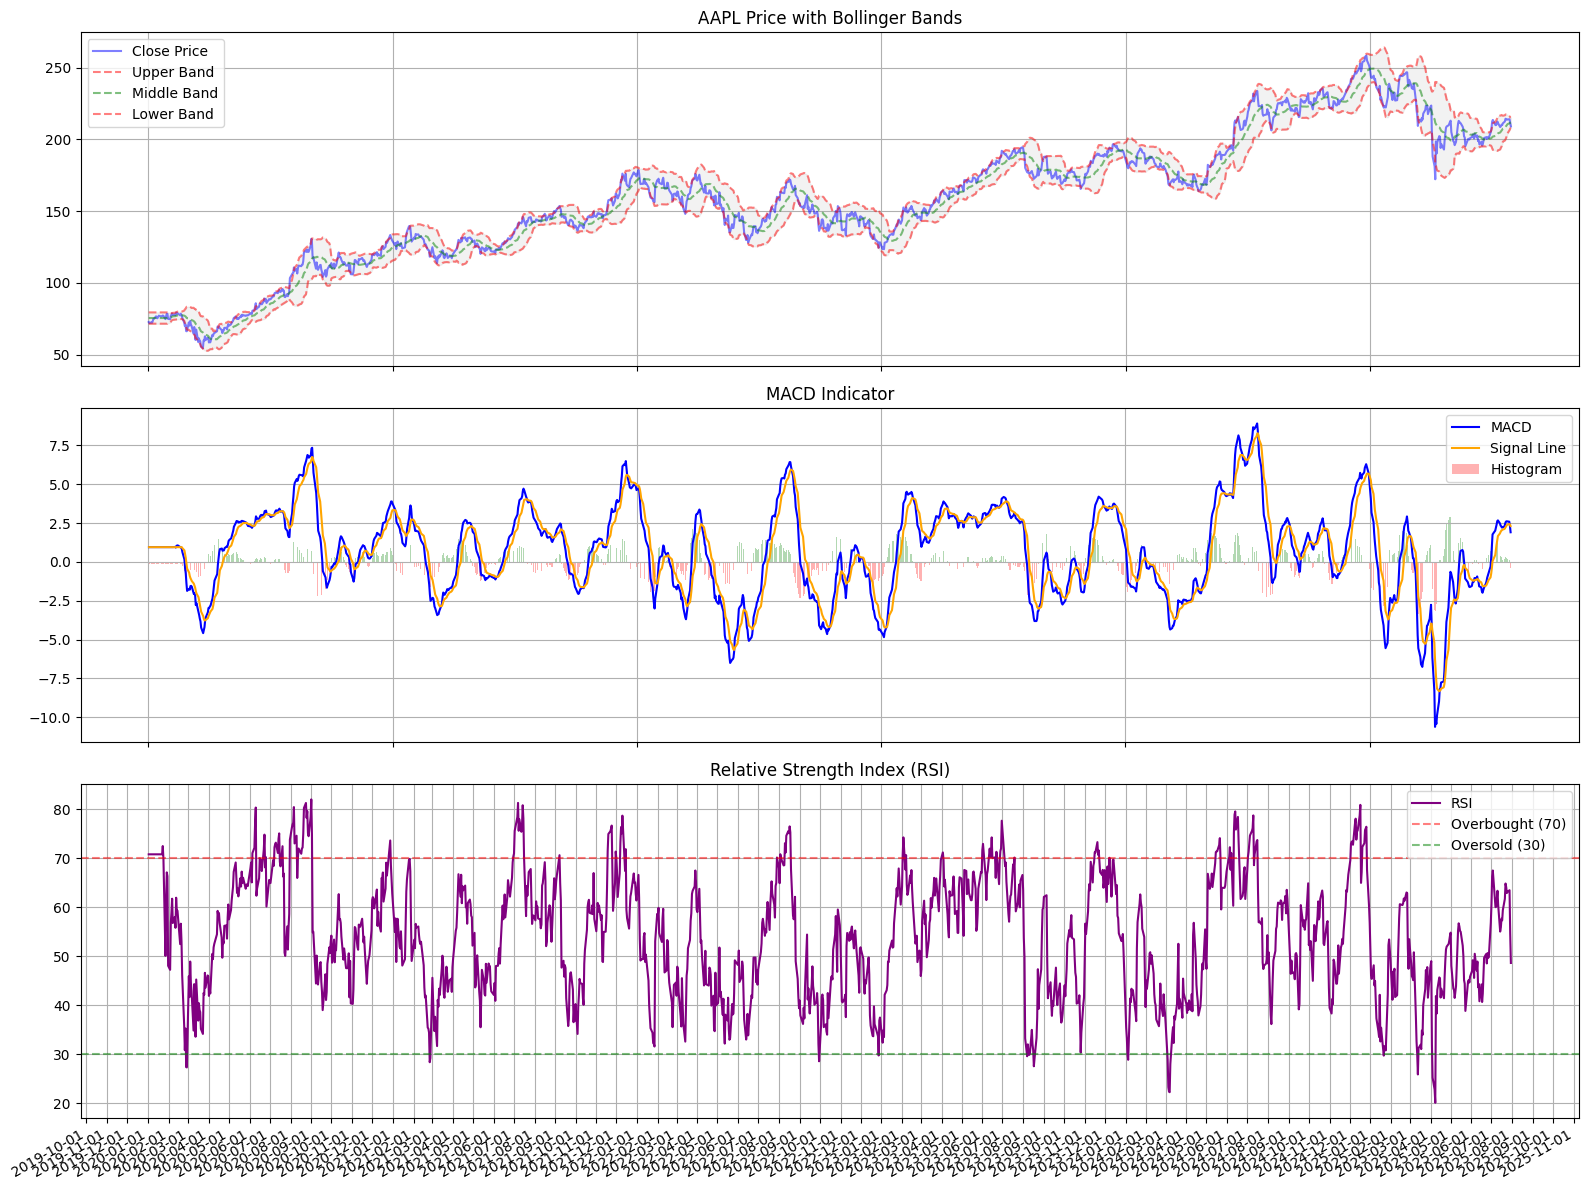

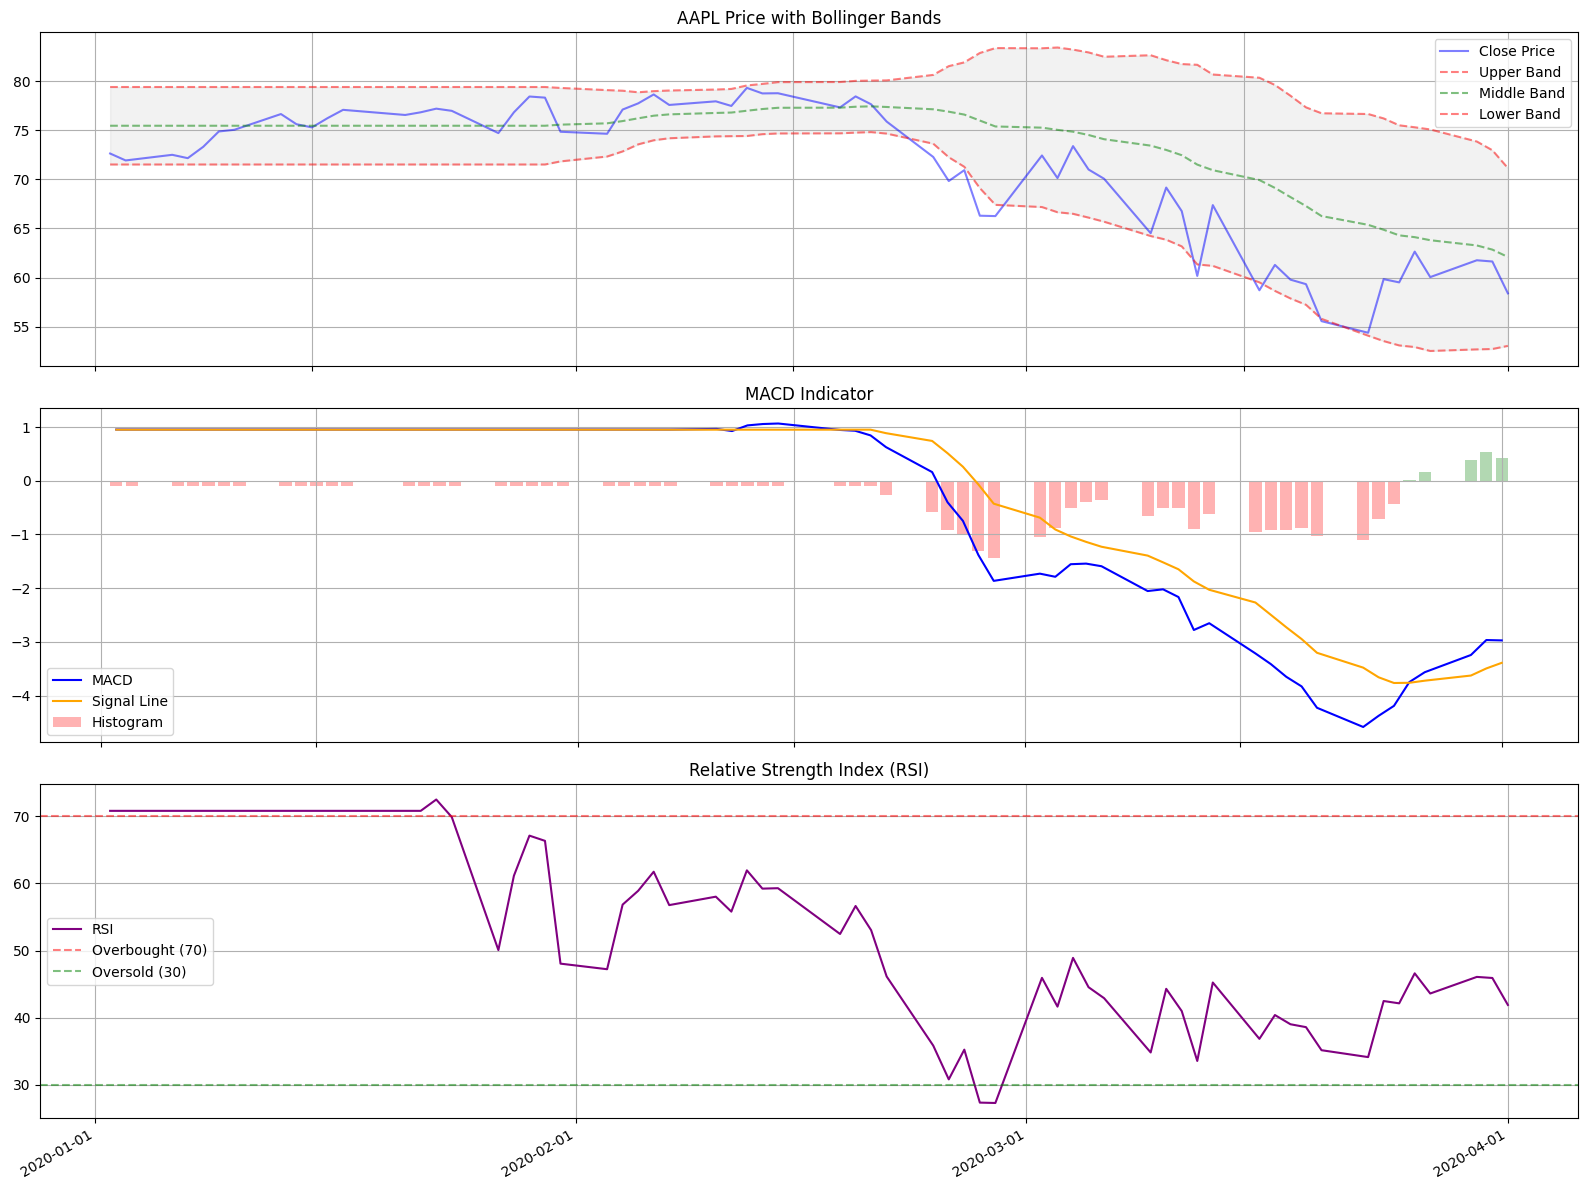

In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_technical_indicators(df, ticker='AAPL', start_date=None, end_date=None):
    """
    Plot price data and technical indicators for visual inspection
    
    Parameters:
    df - DataFrame with price data and indicators
    ticker - stock ticker symbol (for title)
    start_date - optional start date for zooming
    end_date - optional end date for zooming
    """
    # Create a copy and set Date as index
    plot_df = df.copy()
    plot_df['Date'] = pd.to_datetime(plot_df['Date'])
    plot_df = plot_df.set_index('Date')
    
    # Filter by date range if provided
    if start_date is not None and end_date is not None:
        plot_df = plot_df.loc[start_date:end_date]
    
    # Create figure with subplots
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Price data with Bollinger Bands
    plt.subplot(3, 1, 1)
    plt.plot(plot_df['Close'], label='Close Price', color='blue', alpha=0.5)
    plt.plot(plot_df['BB_Upper'], label='Upper Band', color='red', linestyle='--', alpha=0.5)
    plt.plot(plot_df['BB_Middle'], label='Middle Band', color='green', linestyle='--', alpha=0.5)
    plt.plot(plot_df['BB_Lower'], label='Lower Band', color='red', linestyle='--', alpha=0.5)
    plt.fill_between(plot_df.index, plot_df['BB_Lower'], plot_df['BB_Upper'], color='grey', alpha=0.1)
    plt.title(f'{ticker} Price with Bollinger Bands')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: MACD and Signal Line
    plt.subplot(3, 1, 2)
    plt.plot(plot_df['MACD'], label='MACD', color='blue')
    plt.plot(plot_df['MACD_Signal'], label='Signal Line', color='orange')
    # Plot histogram (difference between MACD and Signal)
    plt.bar(plot_df.index, plot_df['MACD_Hist'], label='Histogram', color=np.where(plot_df['MACD_Hist'] > 0, 'g', 'r'), alpha=0.3)
    plt.title('MACD Indicator')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: RSI
    plt.subplot(3, 1, 3)
    plt.plot(plot_df['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
    plt.axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
    plt.title('Relative Strength Index (RSI)')
    plt.legend()
    plt.grid(True)
    
    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

# Plot the entire dataset
plot_technical_indicators(full_data['AAPL'], ticker='AAPL')

# Plot a specific time period (e.g., first 100 days)
plot_technical_indicators(full_data['AAPL'], ticker='AAPL', 
                         start_date='2020-01-01', 
                         end_date='2020-04-01')

In [84]:
class StockNet(nn.Module):
    def __init__(self, num_price_feat, news_dim=768, hidden=128):
        super().__init__()
        self.lstm = nn.LSTM(num_price_feat, hidden, batch_first=True, num_layers=2, dropout=0.2)
        self.fc_news = nn.Sequential(
            nn.Linear(news_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden*2, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, 2)  # دو کلاس: صعودی/نزولی
        )

    def forward(self, x_num, x_news):
        _, (h_n, _) = self.lstm(x_num)
        h_num = h_n[-1]  # آخرین لایه مخفی
        h_news = self.fc_news(x_news)
        fused = torch.cat([h_num, h_news], dim=1)
        return self.classifier(fused)

In [85]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total, correct = 0, 0
    total_loss = 0
    for x_num, x_news, y in loader:
        x_num, x_news, y = x_num.to(device), x_news.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x_num, x_news)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = out.argmax(1)
        total += y.size(0)
        correct += (preds == y).sum().item()
    return total_loss / len(loader), correct / total

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    total_loss = 0
    with torch.no_grad():
        for x_num, x_news, y in loader:
            x_num, x_news, y = x_num.to(device), x_news.to(device), y.to(device)
            out = model(x_num, x_news)
            total_loss += criterion(out, y).item()
            preds.extend(out.argmax(1).cpu().tolist())
            labels.extend(y.tolist())
    acc = sum(p == l for p, l in zip(preds, labels)) / len(labels)
    return total_loss / len(loader), acc, preds, labels

In [ ]:
# آموزش مدل
model = StockNet(ds.num_feats.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(400):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

# ارزیابی روی داده تست
test_loss, test_acc, preds, labels = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2%}")

# ذخیره مدل
torch.save(model.state_dict(), "stock_model.pt")

Epoch 1 | Train Loss: 0.7062 | Train Acc: 50.27% | Val Loss: 0.6873 | Val Acc: 51.82%
Epoch 2 | Train Loss: 0.6946 | Train Acc: 51.09% | Val Loss: 0.6894 | Val Acc: 50.36%
Epoch 3 | Train Loss: 0.7054 | Train Acc: 50.09% | Val Loss: 0.7009 | Val Acc: 46.72%
Epoch 4 | Train Loss: 0.6963 | Train Acc: 51.73% | Val Loss: 0.6920 | Val Acc: 51.82%
Epoch 5 | Train Loss: 0.6977 | Train Acc: 51.09% | Val Loss: 0.7005 | Val Acc: 48.91%
Epoch 6 | Train Loss: 0.6980 | Train Acc: 52.37% | Val Loss: 0.7045 | Val Acc: 45.99%
Epoch 7 | Train Loss: 0.6910 | Train Acc: 51.92% | Val Loss: 0.7020 | Val Acc: 51.09%
Epoch 8 | Train Loss: 0.6901 | Train Acc: 53.74% | Val Loss: 0.7023 | Val Acc: 48.18%
Epoch 9 | Train Loss: 0.6869 | Train Acc: 53.47% | Val Loss: 0.7097 | Val Acc: 51.09%
Epoch 10 | Train Loss: 0.6856 | Train Acc: 54.20% | Val Loss: 0.7184 | Val Acc: 47.45%
Epoch 11 | Train Loss: 0.6930 | Train Acc: 54.20% | Val Loss: 0.7096 | Val Acc: 51.82%
Epoch 12 | Train Loss: 0.6863 | Train Acc: 55.11% | 

In [97]:
#کلاس آماده برای استفاده تجاری

FEATURE_COLS = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD',
                'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle',
                'BB_Lower', 'VWAP']

class StockPredictor:
    def __init__(self, model_path, scaler, tokenizer, bert, lookback=30):
        self.model = StockNet(num_price_feat=scaler.n_features_in_).to(device)
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.eval()
        self.scaler = scaler
        self.tokenizer = tokenizer
        self.bert = bert
        self.lookback = lookback

    def predict_today(self, price_df_last_days, news_title):
        # num_feats = price_df_last_days.select_dtypes(include=[np.number]).values
        
        # Select only the feature columns used for training
        num_feats = price_df_last_days[FEATURE_COLS].values
        
        num_feats = self.scaler.transform(num_feats)[-self.lookback:]
        x_num = torch.tensor(num_feats, dtype=torch.float32).unsqueeze(0).to(device)

        tok = self.tokenizer(news_title, return_tensors='pt', truncation=True, max_length=64).to(device)
        with torch.no_grad():
            x_news = self.bert(**tok).pooler_output

        with torch.no_grad():
            out = self.model(x_num, x_news)
            prob = torch.softmax(out, dim=1)[0]
            direction = "UP" if prob[1] > 0.5 else "DOWN"
        return direction, prob[1].item()

class TradingBot:
    def __init__(self, predictor, initial_balance=10000):
        self.predictor = predictor
        self.balance = initial_balance
        self.holdings = {}
        self.trade_history = []

    def make_trading_decision(self, ticker, price_df, news_title):
        current_price = price_df['Close'].iloc[-1]
        direction, confidence = self.predictor.predict_today(price_df, news_title)

        if direction == "UP" and confidence > 0.7:
            amount = self.balance * 0.1
            shares = amount / current_price
            self.balance -= amount
            self.holdings[ticker] = self.holdings.get(ticker, 0) + shares
            self.trade_history.append({
                'date': datetime.now(),
                'action': 'BUY',
                'ticker': ticker,
                'shares': shares,
                'price': current_price,
                'confidence': confidence
            })
            return f"Bought {shares:.2f} shares of {ticker} at {current_price:.2f}"
        elif direction == "DOWN" and confidence > 0.7 and ticker in self.holdings:
            shares = self.holdings[ticker]
            amount = shares * current_price
            self.balance += amount
            del self.holdings[ticker]
            self.trade_history.append({
                'date': datetime.now(),
                'action': 'SELL',
                'ticker': ticker,
                'shares': shares,
                'price': current_price,
                'confidence': confidence
            })
            return f"Sold {shares:.2f} shares of {ticker} at {current_price:.2f}"
        return "No action taken"

    def get_portfolio_value(self, ticker):
        current_value = self.balance
        if ticker in self.holdings:
            data = yf.download(ticker, period="1d")
            current_price = data['Close'].iloc[-1]
            current_value += self.holdings[ticker] * current_price
        return current_value

In [104]:
# شبیه‌سازی و نمایش داده‌های نمونه

last_30_days = full_data['AAPL'].tail(31).iloc[:-1]
today_news = "Apple announces record buyback program"
predictor = StockPredictor("stock_model.pt", ds.scaler, tokenizer, bert)
direction, confidence = predictor.predict_today(last_30_days, today_news)
print(f"Prediction for tomorrow: {direction} with confidence {confidence:.2%}")

# ربات معاملاتی
bot = TradingBot(predictor)
decision = bot.make_trading_decision('AAPL', last_30_days, today_news)
portfolio_value = bot.get_portfolio_value('AAPL')
print(f"Trading Decision: {decision}")
print(f"Portfolio Value: ${portfolio_value:.2f}")

Prediction for tomorrow: DOWN with confidence 46.11%
Trading Decision: No action taken
Portfolio Value: $10000.00
